## AFT - Multiple Image Example Notebook

In [2]:
from platform import python_version

print(python_version())

3.12.3


In [5]:
cd /home/dvanschie/analyses/20250122_paulPDAC_rebuttal_analysis

/gpfs/home2/dvanschie/analyses/20250122_paulPDAC_rebuttal_analysis


In [6]:
%matplotlib notebook
%matplotlib ipympl
    
from pathlib import Path
AFT_DIR = Path("AFT-Alignment_by_Fourier_Transform/Python_implementation")

import sys
sys.path.insert(0, str(AFT_DIR))      # add the folder, not the file
import AFT_tools as AFT               # AFT (Alignment by Fourier Transform) functions
print(AFT.__file__)                   # sanity check

/gpfs/home2/dvanschie/analyses/20250122_paulPDAC_rebuttal_analysis/AFT-Alignment_by_Fourier_Transform/Python_implementation/AFT_tools.py


In [7]:
import skimage.io as io                 # For reading in images
import AFT_tools as AFT                 # AFT (Alignment by Fourier Transform) functions
import matplotlib.pyplot as plt         # For plotting

# Read in images and define parameters


In [10]:
path_to_image = 'images/A-10.tif_center_6284x6284_at_1479_1479_grayscale16.tif'
path_output =  'output/'

In [11]:
# read image
im = io.imread(path_to_image)

In [15]:
# AFT parameters

#### required parameters ####
window_size = 45
overlap = 0.5
neighborhood_radius = 5

#### optional parameters ####
intensity_threshold = 20
eccentricity_threshold = 0.4

# Calculate the local orientation

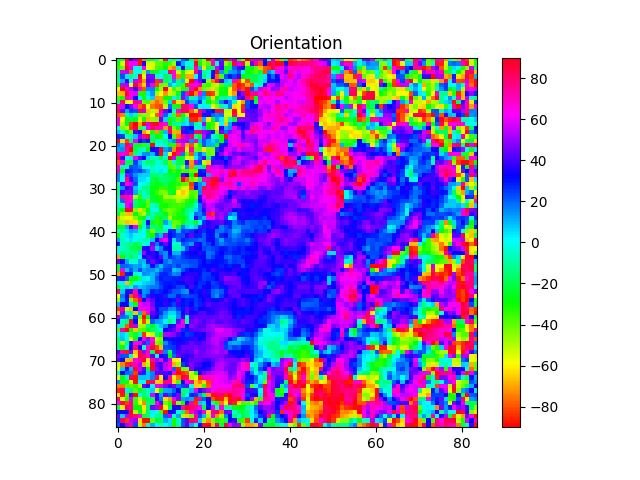

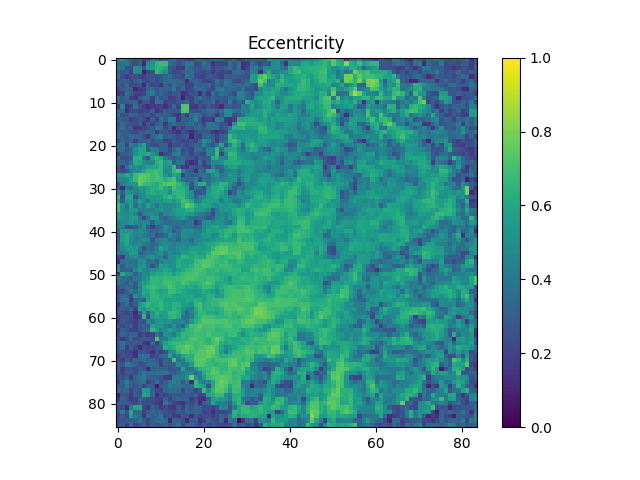

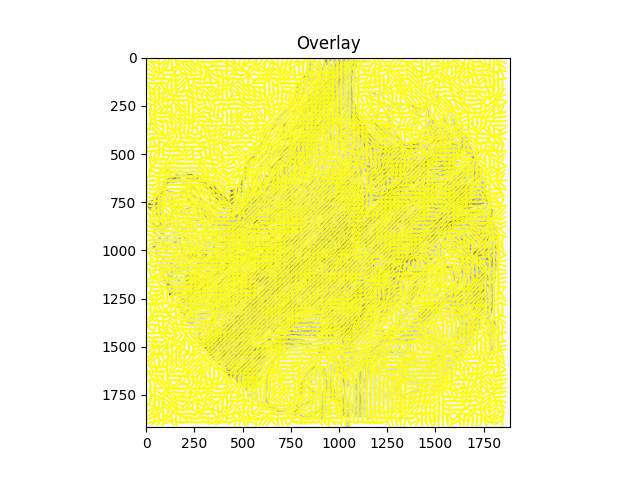

In [16]:
x, y, u, v, im_theta, im_eccentricity = AFT.image_local_order(im, window_size, overlap, save_path=path_output, 
                                                             plot_overlay=True, plot_angles=True, plot_eccentricity=True,
                                                             save_figures=True)

# Calculate the order parameter


In [23]:
im_order_parameter = AFT.calculate_order_parameter(im_theta, neighborhood_radius)
print('The order parameter is {0}'.format(im_order_parameter))

The order parameter is 0.506287991538729


In [29]:
im_order_parameter

0.506287991538729

In [14]:
# === Batch runner for AFT ===
# Runs over all images in a folder, saves outputs per image, and writes a CSV of order parameters.

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, color

# Import your functions
from AFT_tools import image_local_order, calculate_order_parameter  # requires AFT_tools.py in the same working dir

# ----------------- USER SETTINGS -----------------
INPUT_DIR  = r"images"      # folder with input images
OUTPUT_DIR = r"output"         # where overlays/heatmaps + CSV will be written

# AFT parameters (tweak as desired)
WINDOW_SIZE          = 45      # odd; local window size (pixels)
OVERLAP              = 0.5     # 0–1; step as a fraction of window size
NEIGHBORHOOD_RADIUS  = 5       # in 'vector grid' units (NOT pixels)
INTENSITY_THRESH     = 0       # mean-intensity threshold per window
ECCENTRICITY_THRESH  = 0       # 0–1; filter weak orientation windows

# What to save for each image
SAVE_OVERLAY         = True    # quiver over raw image
SAVE_ANGLE_MAP       = True    # heatmap (degrees) of local orientation
SAVE_ECC_MAP         = True   # heatmap of local eccentricity
# -------------------------------------------------

Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Allowed image extensions (feel free to extend)
ALLOWED_EXTS = {".tif", ".tiff", ".png", ".jpg", ".jpeg", ".bmp"}

results = []

img_paths = sorted(p for p in Path(INPUT_DIR).glob("**/*") if p.suffix.lower() in ALLOWED_EXTS)
if not img_paths:
    raise FileNotFoundError(f"No images with {sorted(ALLOWED_EXTS)} found under {INPUT_DIR}")

for i, img_path in enumerate(img_paths, start=1):
    base = img_path.stem
    print(f"[{i}/{len(img_paths)}] Processing: {img_path.name}")

    # --- Load + ensure grayscale float32 ---
    im = io.imread(str(img_path))
    if im.ndim == 3:   # RGB/RGBA -> grayscale
        im = color.rgb2gray(im)
    im = im.astype("float32")

    # --- Compute local orientation (theta grid) & eccentricity ---
    # We let the function keep plotting off; we'll do our own plots with the right basenames.
    x, y, u, v, theta, ecc = image_local_order(
        im,
        window_size=WINDOW_SIZE,
        overlap=OVERLAP,
        im_mask=None,
        intensity_thresh=INTENSITY_THRESH,
        eccentricity_thresh=ECCENTRICITY_THRESH,
        plot_overlay=False,
        plot_angles=False,
        plot_eccentricity=False,
        save_figures=False,
        save_path=""
    )

    # --- Order parameter (single scalar per image) ---
    order_param = float(
        calculate_order_parameter(theta, neighborhood_radius=NEIGHBORHOOD_RADIUS)
    )

    # --- Save figures with the *right name* (based on input basename) ---
    # Overlay (quiver over raw image)
    if SAVE_OVERLAY:
        plt.figure()
        plt.imshow(im, cmap='Greys_r')
        # Note: x, y, u, v are the vector grid positions & components returned by image_local_order
        plt.quiver(
            x, y, u, v,
            color="yellow",
            pivot="mid",
            scale_units="xy",
            scale=OVERLAP/2,   # matches helper's convention
            headaxislength=0,
            headlength=0,
            width=0.005
        )
        plt.title(f"{base} — orientation overlay")
        plt.axis("off")
        out_path = Path(OUTPUT_DIR, f"{base}_overlay.png")
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        plt.close()

    # Angle map (in degrees, -90..90); theta is a 2D grid over windows (NOT pixels)
    if SAVE_ANGLE_MAP:
        plt.figure()
        plt.imshow(theta * 180 / np.pi, vmin=-90, vmax=90, cmap="hsv")
        plt.colorbar(label="Angle (°)")
        plt.title(f"{base} — local orientation (window grid)")
        out_path = Path(OUTPUT_DIR, f"{base}_angle.png")
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        plt.close()

    # Eccentricity map (0..1) on the same window grid
    if SAVE_ECC_MAP:
        plt.figure()
        plt.imshow(ecc, vmin=0, vmax=1)
        plt.colorbar(label="Eccentricity")
        plt.title(f"{base} — local eccentricity (window grid)")
        out_path = Path(OUTPUT_DIR, f"{base}_ecc.png")
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        plt.close()

    # Record result row
    results.append({
        "filename": img_path.name,
        "path": str(img_path),
        "order_parameter": order_param,
        "window_size": WINDOW_SIZE,
        "overlap": OVERLAP,
        "neighborhood_radius": NEIGHBORHOOD_RADIUS,
        "intensity_thresh": INTENSITY_THRESH,
        "eccentricity_thresh": ECCENTRICITY_THRESH,
        "theta_rows": int(theta.shape[0]),
        "theta_cols": int(theta.shape[1]),
        "img_height": int(im.shape[0]),
        "img_width": int(im.shape[1]),
    })

# --- Write CSV with one row per image ---
df = pd.DataFrame(results)
csv_path = Path(OUTPUT_DIR, "order_parameters.csv")
df.to_csv(csv_path, index=False)
print(f"\nSaved CSV: {csv_path}")
print("Done.")


[1/47] Processing: A-1.tif_center_6414x6522_at_1510_1535_grayscale16.tif
[2/47] Processing: A-10.tif_center_6284x6284_at_1479_1479_grayscale16.tif
[3/47] Processing: A-2.tif_center_6495x6742_at_1528_1586_grayscale16.tif
[4/47] Processing: A-3.tif_center_6425x6588_at_1512_1550_grayscale16.tif
[5/47] Processing: A-4.tif_center_6284x6284_at_1479_1479_grayscale16.tif
[6/47] Processing: A-5.tif_center_6555x6476_at_1543_1524_grayscale16.tif
[7/47] Processing: A-6.tif_center_6283x6283_at_1479_1479_grayscale16.tif
[8/47] Processing: A-7.tif_center_6311x6871_at_1485_1617_grayscale16.tif
[9/47] Processing: A-8.tif_center_6284x6852_at_1479_1613_grayscale16.tif
[10/47] Processing: A-9.tif_center_6284x6284_at_1479_1479_grayscale16.tif
[11/47] Processing: B-1.tif_center_6440x6497_at_1515_1529_grayscale16.tif
[12/47] Processing: B-10.tif_center_6577x6601_at_1548_1553_grayscale16.tif
[13/47] Processing: B-2.tif_center_6421x6497_at_1511_1529_grayscale16.tif
[14/47] Processing: B-3.tif_center_6284x6444_